# Простая полносвязная нейросеть для классификации имен

Источники:

1) FFNN: https://medium.com/swlh/sentiment-classification-using-feed-forward-neural-network-in-pytorch-655811a0913f

2) Датасет и некоторые сопутствующие функции: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

## Загрузка данных

In [ ]:
import os
from collections import defaultdict

In [ ]:
from tqdm import tqdm

In [ ]:
import random

Ближайшие несколько занятий мы будем работать с библиотекой [pytorch](https://pytorch.org/) - одной из самых известных и часто применяющихся библиотек для глубокого обучения, на которой легко можно написать нейросеть с нуля.

In [ ]:
import torch

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Наши данные - это списки имен, записанных латиницей и отсортированных по происхождению.

In [ ]:
category_lines = defaultdict(list)

for filename in os.listdir('/content/drive/MyDrive/ML_training_data/names'):
  category_name = filename[:-4]
  with open(os.path.join('/content/drive/MyDrive/ML_training_data/names', filename), 'r') as f:
    lines = f.read().strip().split('\n')
    category_lines[category_name] = lines

In [ ]:
category_lines.keys()

dict_keys(['Chinese', 'Arabic', 'Czech', 'German', 'Korean', 'Japanese', 'Dutch', 'Polish', 'French', 'Greek', 'Portuguese', 'Scottish', 'Irish', 'Spanish', 'English', 'Italian', 'Vietnamese', 'Russian'])

In [ ]:
print(category_lines['Czech'][105:115])

['Grabski', 'Grozmanova', 'Grulich', 'Grygarova', 'Hadash', 'Hafernik', 'Hajek', 'Hajicek', 'Hajkova', 'Hana']


Нам необходимо закодировать имена и категории. Начнем с имен.

Мы применим простой способ кодирования имен, подобный принципу работы CountVectorizer: для каждого имени будем создавать вектор, равный общему количеству уникальных букв. Если буква присутствует в имени, в вектор записывается число раз, когда буква в имени встречается; если нет, по этому индексу остается 0.

In [ ]:
unique_letters = set()

for k, v in category_lines.items():
  for word in v:
    unique_letters.update(set(word))

In [ ]:
all_letters = list(unique_letters)
n_letters = len(all_letters)

Что, если когда-нибудь наша модель увидит символ, который не видела на этапе обучения? Для этого мы предусмотрим дополнительный, последний индекс, который будет отвечать за хранение неизвестных символов.

In [ ]:
n_letters += 1

В глубоком обучении большую роль играет то, какие мощности (hardware) вам доступны. Некоторые виды видеокарт поддерживают более быстрое обучение нейросетей. Если вам доступна соответствующая GPU, можно проводить вычисления на ней.

Если вы хотите использовать GPU в своем ноутбуке, выберите Runtime -> Change runtime type -> T4 GPU.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


### Кодирование слов. Тензоры.

Тензоры - это особая структура данных, поддерживаемая pytorch. Тензоры похожи на numpy-массивы.

In [ ]:
zero_tensor = torch.zeros(88, dtype=torch.float64, device=device)

In [ ]:
zero_tensor

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', dtype=torch.float64)

In [ ]:
print(all_letters)

['ń', 'Q', 'ò', "'", 'ù', ',', 'V', 'k', 'J', 'M', 't', 'c', 'x', 'q', 'ú', 'L', 'z', 'ê', 'Z', 'Y', 'ą', ':', 'C', 'ì', 'h', 'ç', 'K', 'T', 'U', 'S', 'ó', 'É', 'Ż', 'd', '\xa0', 'r', 'Ś', 'é', 'I', 'w', 'y', 'B', 'õ', 'p', 'X', 'E', 'F', ' ', 'í', 'v', 'g', 'b', 'H', 'ż', 'm', 'R', 'G', 'ö', 'n', 'e', 'u', 'j', '-', 'O', 'ñ', 'l', 'P', 'A', 'W', 'f', 'á', '1', 'ã', 'i', 'N', 'ł', 'à', 's', 'ä', 'ü', 'a', '/', 'ß', 'D', 'Á', 'è', 'o']


In [ ]:
'&' in all_letters

False

In [ ]:
word = 'Madeline&'

for letter in word:
  if letter in all_letters:
    ind = all_letters.index(letter)
    zero_tensor[ind] += 1
  else:
    zero_tensor[-1] += 1

In [ ]:
zero_tensor

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.],
       device='cuda:0', dtype=torch.float64)

In [ ]:
def line_to_flat_tensor(line):
  # параметр device позволяет посылать тензоры на GPU:
    tensor = torch.zeros(n_letters, dtype=torch.float64, device=device)
    for letter in line:
      if letter in all_letters:
        tensor[all_letters.index(letter)] += 1
      else:
        tensor[-1] += 1
    return tensor.view(1, -1).float()

print(line_to_flat_tensor('Jones').size())

torch.Size([1, 88])


In [ ]:
line_to_flat_tensor('Zahar')

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')

Проверим, сколько у нас категорий всего:

In [ ]:
all_categories = list(category_lines.keys())

In [ ]:
len(all_categories)

18

## Нейросеть

Наша нейросеть будет иметь следующую структуру:


*   1 полносвязный слой с количеством нейронов, равным количеству уникальных букв;
*   1 скрытый слой с одинаковым количеством нейронов, которое мы зададим сами;
*   Выходной слой, определяющий происхождение имени, количество нейронов в котором равно количеству возможных категорий.

После каждого слоя будет функция активации. Активацией последнего слоя будет софтмакс, т.к. у нас мультиклассовая классификация, а софтмакс возвращает вероятности от 0 до 1 в сумме (в отличие от сигмоиды, которая возвращает вероятности для каждого класса по отдельности).



In [ ]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()

        # Linear function 1: vocab_size --> hidden_dim
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # Non-linearity 1
        self.relu1 = nn.ReLU()

        # Linear function 2: hidden_dim --> hidden_dim
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 2
        self.relu2 = nn.ReLU()

        # Linear function 3 (readout): hidden_dim --> output_dim
        self.fc3 = nn.Linear(hidden_dim, output_dim)

        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Linear function 1
        out = self.fc1(x)
        # Non-linearity 1
        out = self.relu1(out)

        # Linear function 2
        out = self.fc2(out)
        # Non-linearity 2
        out = self.relu2(out)

        # Linear function 3 (readout)
        out = self.fc3(out)

        return self.softmax(out)

## Обучение нейросети

Для начала, как обычно, разделим данные на тренировочные и тестовые. Мы сделаем два списка, в первом из которых будут слова, а во втором - соответствующие им категории, и затем разделим эти списки, выполнив стратификацию по второму.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = []
y = []

for k, v in category_lines.items():
  for w in v:
    X.append(w)
    y.append(k)

In [ ]:
len(X) == len(y)

True

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True)

Определим параметры нашей нейросети. Также подберем функцию потерь и метод оптимизации. Выбор функции потерь обусловлен функцией активации последнего слоя.

In [ ]:
input_dim = n_letters
hidden_dim = 50
output_dim = len(all_categories)
num_epochs = 200

ff_nn_bow_model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)
ff_nn_bow_model.to(device)

loss_function = nn.NLLLoss()
optimizer = optim.SGD(ff_nn_bow_model.parameters(), lr=0.01)

Начинаем обучение. Мы будем сохранять значение функции потерь на каждом этапе, чтобы потом посмотреть, как она менялась.

In [ ]:
losses = []

for epoch in tqdm(range(num_epochs)):
    train_loss = 0

    # Делаем минибатч: случайным образом выбираем тысячу имен, на которых будем тренироваться в этой итерации
    current_batch = random.sample(range(len(X_train)), 1000)
    current_X_train = [X_train[i] for i in current_batch]
    current_y_train = [y_train[i] for i in current_batch]

    for current_word, current_category in zip(current_X_train, current_y_train):
      # Очищаем градиент, аккумулированный на предыдущих этапах
      optimizer.zero_grad()

      # кодируем имя и категорию, превращая их в тензоры
      line_tensor = line_to_flat_tensor(current_word)
      category_tensor = torch.tensor([all_categories.index(current_category)], dtype=torch.long)

      # forward pass: обновляем веса и получаем вероятности классов для слова
      probs = ff_nn_bow_model(line_tensor.to(device))

      # считаем значение функции потерь и добавляем его к общему лоссу этой эпохи
      loss = loss_function(probs, category_tensor.to(device))
      train_loss += loss.item()

      # backward pass: распространяем ошибку обратно, чтобы проапдейтить веса
      loss.backward()

      # Апдейтим веса
      optimizer.step()

    losses.append(train_loss)
    # перед следующей эпохой зануляем лосс
    train_loss = 0

100%|██████████| 200/200 [04:34<00:00,  1.37s/it]


## Оценка работы модели

Давайте для начала посмотрим, удалось ли нам постепенно снизить ошибку.

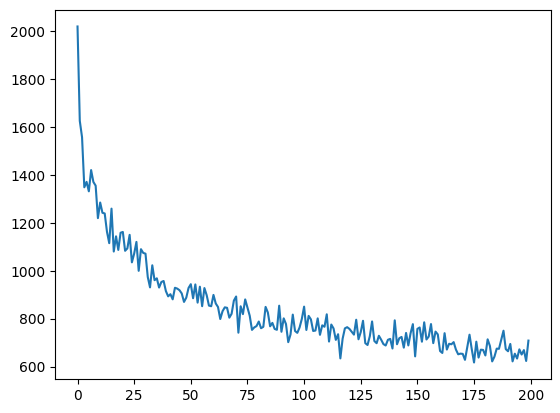

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)

In [ ]:
max(losses)

2019.8678170591593

In [ ]:
min(losses)

616.8805826893158

Теперь оценим качество модели стандартными способами для классификации:

In [ ]:
from sklearn.metrics import classification_report

bow_ff_nn_predictions = []
original_lables_ff_bow = []

# этот метод означает, что нам не нужно считать градиент для обратного распространения ошибки, а нужно сделать только предсказания
with torch.no_grad():
  for word, cat in zip(X_test, y_test):
    line_tensor = line_to_flat_tensor(word)
    category_tensor = torch.tensor([all_categories.index(cat)], dtype=torch.long)

    probs = ff_nn_bow_model(line_tensor)
    bow_ff_nn_predictions.append(torch.argmax(probs, dim=1).cpu().numpy()[0])
    original_lables_ff_bow.append(all_categories.index(cat))

In [ ]:
print(classification_report(original_lables_ff_bow, bow_ff_nn_predictions, target_names=all_categories))

              precision    recall  f1-score   support

     Chinese       0.51      0.57      0.54        67
      Arabic       0.85      0.99      0.92       500
       Czech       0.26      0.11      0.15       130
      German       0.34      0.39      0.36       181
      Korean       0.33      0.08      0.13        24
    Japanese       0.79      0.68      0.73       248
       Dutch       0.73      0.11      0.19        74
      Polish       0.54      0.20      0.29        35
      French       0.56      0.07      0.13        69
       Greek       0.76      0.25      0.38        51
  Portuguese       0.00      0.00      0.00        18
    Scottish       0.00      0.00      0.00        25
       Irish       0.71      0.21      0.32        58
     Spanish       0.31      0.27      0.29        75
     English       0.61      0.71      0.66       917
     Italian       0.51      0.42      0.46       177
  Vietnamese       0.17      0.06      0.08        18
     Russian       0.85    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


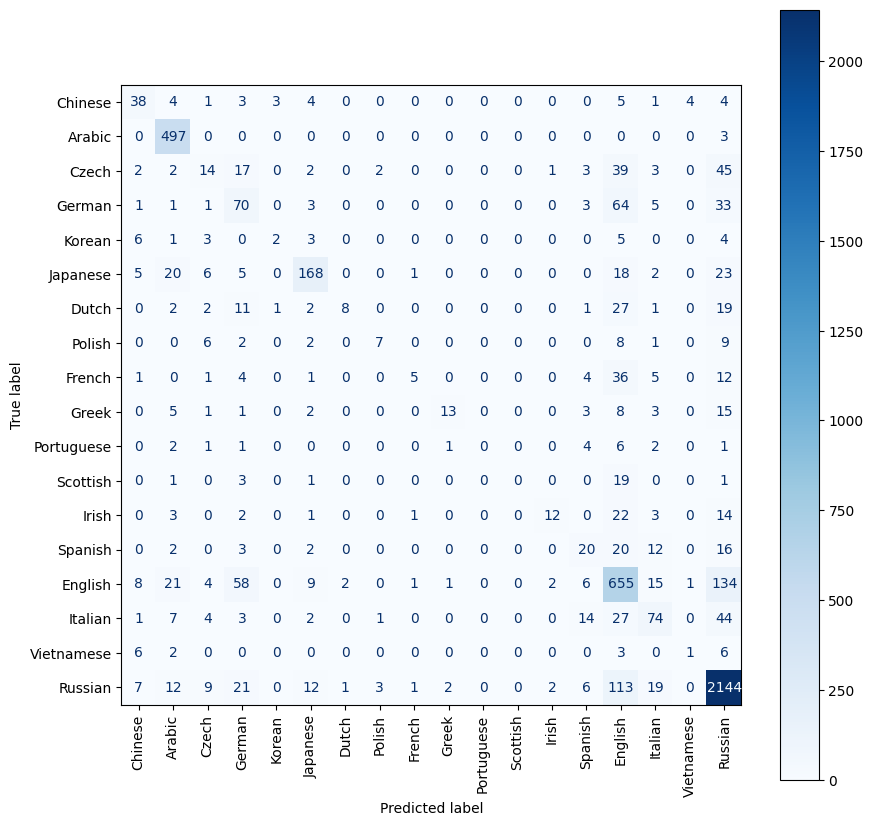

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(original_lables_ff_bow,
                                        bow_ff_nn_predictions,
                                        display_labels=all_categories,
                                        ax=ax,
                                        xticks_rotation='vertical', cmap='Blues')

Бонус: давайте предскажем несуществующее имя!

In [ ]:
not_a_name = '2Xzae36'

Его тоже нужно превратить в тензор:

In [ ]:
line_tensor = line_to_flat_tensor(not_a_name)

Получим предсказание модели:

In [ ]:
probs = ff_nn_bow_model(line_tensor)

In [ ]:
probs

tensor([[-1.0490, -5.5317, -1.7644, -2.4115, -2.5820, -3.2276, -5.9818, -4.0513,
         -5.7973, -9.2598, -5.1045, -6.6707, -6.2329, -3.6091, -3.7309, -3.8182,
         -2.9217, -2.2046]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)

К какой же категории относится слово?

In [ ]:
category_ind = torch.argmax(probs, dim=1).cpu().numpy()[0]

In [ ]:
all_categories[category_ind]

'Chinese'